In [355]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML
from mpl_toolkits.mplot3d import Axes3D
from htmresearch.support.gridcells.context_integration.context_layer import ContextLayer
from htmresearch.support.gridcells.context_integration.utils import (create_module_shape, 
                                                                     create_action_tensor, 
                                                                     get_actions, 
                                                                     get_3d_actions,
                                                                     get_closed_3d_path,
                                                                     load_digit_features)

from scipy.stats import entropy

%matplotlib inline
%load_ext autoreload
%autoreload 2



# m = 5   # Number of modules
# n = 23   # Approximate number of cells per module dimension
# d = 15   # Cells per minicolumn
# w = 10   # Code weight of the sensory SDR

FAC = 1

m = 5     # Number of modules
n = 25   # Approximate number of cells per module dimension
d = 8   # Cells per minicolumn
w = 3   # Code weight of the sensory SDR

zero = np.zeros(2*m)

# dx,dy,dz = get_actions(m,3)
dx,dy = get_actions(m,2)
dz = dx + 9*dy



module_shapes = create_module_shape(m,n, rmin=-10,rmax=5)
action_tensor = create_action_tensor(m) 

X, V = get_closed_3d_path(num_samples=20, radius=5)

CL  = ContextLayer(layer_height=d, module_shapes=module_shapes, action_map=action_tensor, max_activity=200) 

F = load_digit_features(w=w, shape=CL.layer.shape)

print CL

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload

**Context Layer:**
------------------
Number of cells:	 2216
Layer Shape:		 (8, 277)
Hyper-Module Shapes:
[[18 20]
 [18 16]
 [25 24]
 [21 29]
 [23 15]]
Module bounds: [   0  360  648 1248 1857 2202]
Number of grid cells:	 2202
Activity bound:		 200
------------------


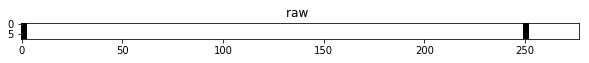

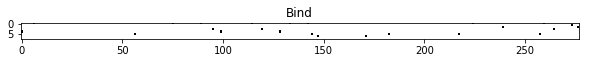

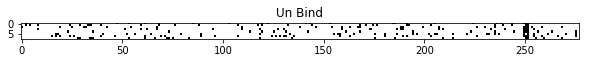

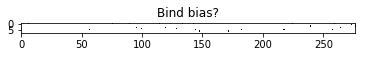

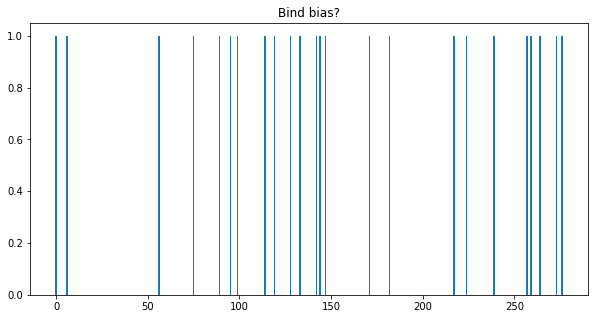

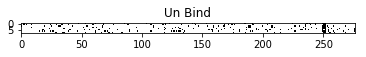

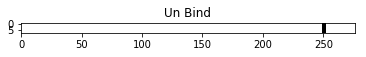

In [357]:
def top_k(score, k):
    return np.argsort(score)[::-1][:k]

vecs_data = [(1,0,1)]
vecs_child = [(-1,2,0)]

num_ex = 10
vecs_data = [ np.random.randint(-15,15, size=3) for _ in range(num_ex)]
vecs_child =  [ np.random.randint(-15,15, size=3) for _ in range(num_ex)]
unbind_vecs = vecs_child

def bind(CL, d, c, vecs_d, vecs_c):
    CL.clear()
    CL.add(d)
    d_ = sum([ CL.explore(a*dx + b*dy + x3*dz, mentally=True) for a,b,x3 in vecs_d])

    CL.clear()
    CL.add(c)
    c_ = sum([ CL.explore(a*dx + b*dy + x3*dz, mentally=True) for a,b,x3 in vecs_c])

    CL.clear()
    CL.add(d_)
    CL.add(c_)

    root = CL.layer
    score = np.sum(root, axis=0)

    CL.clear()
    CL.feed_bottom_up(top_k(score, w))
    return CL.layer.copy()

def bind2(CL, d, c, vecs_d, vecs_c):
    CL.clear()
    CL.add(d)
    d_ = sum([ CL.explore(a*dx + b*dy + x3*dz, mentally=True) for a,b,x3 in vecs_d])

    CL.clear()
    CL.add(c)
    c_ = sum([ CL.explore(a*dx + b*dy + x3*dz, mentally=True) for a,b,x3 in vecs_c])


    root = d_ + c_
    score = np.sum(root, axis=0)

    CL.clear()
    CL.feed_bottom_up(top_k(score, w))
    return CL.layer.copy()

def bind3(CL, x, y, vecs_d, vecs_c):
    CL.clear()
    CL.add(x)
    d_ = sum([ CL.explore(a*dx + b*dy + x3*dz, mentally=True) for a,b,x3 in vecs_d])

    CL.clear()
    CL.add(y)
    c_ = sum([ CL.explore(a*dx + b*dy + x3*dz, mentally=True) for a,b,x3 in vecs_c])


    root = d_ + c_
#     wmax = np.sort(root.reshape(-1))[::-1][w]
#     fingerprint = np.where(root < wmax, 0.,1.)
    fingerprint = np.zeros(root.shape).reshape(-1)

    sorted_args = np.argsort(root.reshape(-1))[::-1]
    top = sorted_args[:(w*d)]
    fingerprint[top] = 1.
    fingerprint = fingerprint.reshape((root.shape))
    CL.clear()
    CL.add(fingerprint)
    return CL.layer.copy()


def unbind(CL, xy, vecs):
    CL.clear()
    CL.add(xy)
    x__ = sum([ CL.explore(-a*dx - b*dy - x3*dz, mentally=True) for a,b,x3 in vecs])

    score = np.sum(x__, axis=0)
    CL.clear()
    CL.feed_bottom_up(top_k(score, w))
    return CL.layer.copy()


def unbind3(CL, xy, vecs):
    CL.clear()
    CL.add(xy)
    x__ = sum([ CL.explore(-a*dx - b*dy - x3*dz, mentally=True) for a,b,x3 in vecs])

#     score = np.sum(x__, axis=0)
    CL.clear()
    CL.add(x__)
#     CL.feed_bottom_up(top_k(score, w))
    return CL.layer.copy()




CL = []
for i in range(1):
    CL.append(ContextLayer(layer_height=d, module_shapes=module_shapes, action_map=action_tensor, max_activity=200))

    
x = F[0]
y = F[9]

xy = []
x_ = []




for i in range(len(CL)):
    xy.append(bind3(CL[i], x,y, vecs_data, vecs_child))
    x_.append(unbind3(CL[i], xy[-1], unbind_vecs))

    
plt.figure(figsize=(10,5))
plt.title("raw ")
plt.imshow(x + y, cmap="binary", vmin=0, vmax=1)
plt.show()



plt.figure(figsize=(10,5))
plt.title("Bind")
plt.imshow(xy[0], cmap="binary")
plt.show()


plt.figure(figsize=(10,5))
plt.title("Un Bind")
plt.imshow(x_[0], cmap="binary")
plt.show()


plt.title("Bind bias?")
plt.imshow(sum(xy), cmap="binary")
plt.show()

plt.figure(figsize=(10,5))
plt.title("Bind bias?")
plt.bar(range(CL[0].layer_shape[1]), np.sum(sum(xy), axis=0))
plt.show()


plt.title("Un Bind")
plt.imshow(sum(x_), cmap="binary")
plt.show()




CL = ContextLayer(layer_height=d, module_shapes=module_shapes, action_map=action_tensor, max_activity=200)
score = np.sum(sum(x_), axis=0)
CL.feed_bottom_up(top_k(score, w))


plt.title("Un Bind")
plt.imshow(CL.layer, cmap="binary")
plt.show()




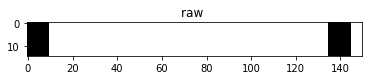

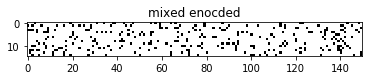

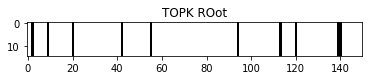

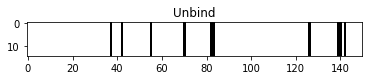

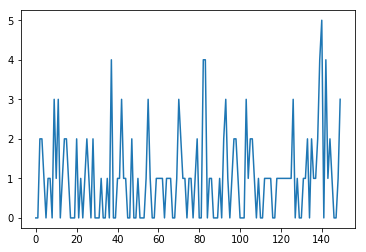

In [451]:
def top_k(score, k):
    return np.argsort(score)[::-1][:k]

CL.clear()

d = F[0]
c = F[9]


plt.title("raw ")
plt.imshow(d + c, cmap="binary", vmin=0, vmax=1)
plt.show()

CL.clear()
CL.extend(zero, d)
d_ = sum([ CL.explore(a*dx + b*dy, mentally=True) for a,b in [(0,1)]])

CL.clear()
CL.extend(zero, c)
c_ = sum([ CL.explore(a*dx + b*dy, mentally=True) for a,b in [(1,0)]])


CL.clear()
CL.add(d_)
CL.add(c_)

plt.title("mixed enocded")
plt.imshow(CL.layer, cmap="binary", vmin=0, vmax=1)
plt.show()


root = CL.layer


score = np.sum(root, axis=0)

CL.clear()
CL.feed_bottom_up(top_k(score, w))


plt.title("TOPK ROot")
plt.imshow(CL.layer, cmap="binary", vmin=0, vmax=1)
plt.show()


d__ = sum([ CL.explore(-a*dx - b*dy, mentally=True) for a,b in [(0,1)]])
c__ = sum([ CL.explore(-a*dx - b*dy, mentally=True) for a,b in [(1,0)]])


score = np.sum(c__, axis=0)

CL.clear()
CL.feed_bottom_up(top_k(score, w))

plt.title("Unbind")
plt.imshow(CL.layer, cmap="binary", vmin=0, vmax=1)
plt.show()

plt.plot(score)
plt.show()
# plt.figure(figsize=(40,20))
# plt.title("Cells that belong to module $M_0$")
# plt.imshow(CL.highlight_module(0), cmap="binary", vmin=0, vmax=1)
